# Machine Learning for String Field Theory

In the context of String Field Theory (SFT), we analyse data from different categories of models and study the truncation levels for various observables. The target is to use machine learning (ML) methods to predict the value of the observables without truncating at finite level.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import re
import urllib
from sklearn import cluster, metrics
from sklearn.model_selection import ParameterGrid
from joblib import Parallel, delayed, dump, load
from nntools import *

## Exploratory Data Analysis

We dedicate the notebook to the exploratory data analysis (EDA). We highlight properties of the variables in the dataset and study recurrences or notable features before moving to inference and feature selection.

In [2]:
df, (n_rows, n_cols) = load_json('https://riccardo.rigoletto.dynu.net/datasets/ml-sft/sft_data.json.gz', orient='index')

Size of the dataset: 3300 rows, 45 columns.


To better handle the various objects, we convert the values to appropriate `dtypes`.

In [3]:
dtypes_dict = {c: np.float32 if c != 'type' and c != 'model' else np.uint8 for c in df.columns}
df = df.astype(dtypes_dict)

# print statistics
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3300 entries, 0 to 3299
Data columns (total 45 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   weight       3300 non-null   float32
 1   type         3300 non-null   uint8  
 2   k            1680 non-null   float32
 3   solution     3280 non-null   float32
 4   j            1680 non-null   float32
 5   m            1680 non-null   float32
 6   level_02_re  3300 non-null   float32
 7   level_02_im  3300 non-null   float32
 8   level_03_re  3300 non-null   float32
 9   level_03_im  3300 non-null   float32
 10  level_04_re  3300 non-null   float32
 11  level_04_im  3300 non-null   float32
 12  level_05_re  3300 non-null   float32
 13  level_05_im  3300 non-null   float32
 14  level_06_re  3300 non-null   float32
 15  level_06_im  3300 non-null   float32
 16  level_07_re  3300 non-null   float32
 17  level_07_im  3300 non-null   float32
 18  level_08_re  3300 non-null   float32
 19  level_

### Statistics of the Variables

Before moving on, we try to get an idea of the variation of the values in each variable. We study `min`, `max`, `mean`, `std`, `median` and others. We **do not** take into account `NaN` or `<NA>` values since *in this case* they would spoil the result. We also exclude the categorical `dtypes` from the computation.

In [4]:
df_stats = df.describe(percentiles=[0.1, 0.25, 0.33, 0.5, 0.66, 0.75, 0.9], exclude=[np.uint8])
df_stats = df_stats.drop(index='count')

For visualisation purposes we also rescale the statistics in the interval $[-1, 1]$. They can then be showed in a heatmap for comparison.

In [5]:
df_stats_norm   = 2 * (df_stats - df_stats.min(axis=0, skipna=True)) / (df_stats.max(axis=0, skipna=True) - df_stats.min(axis=0, skipna=True)) - 1

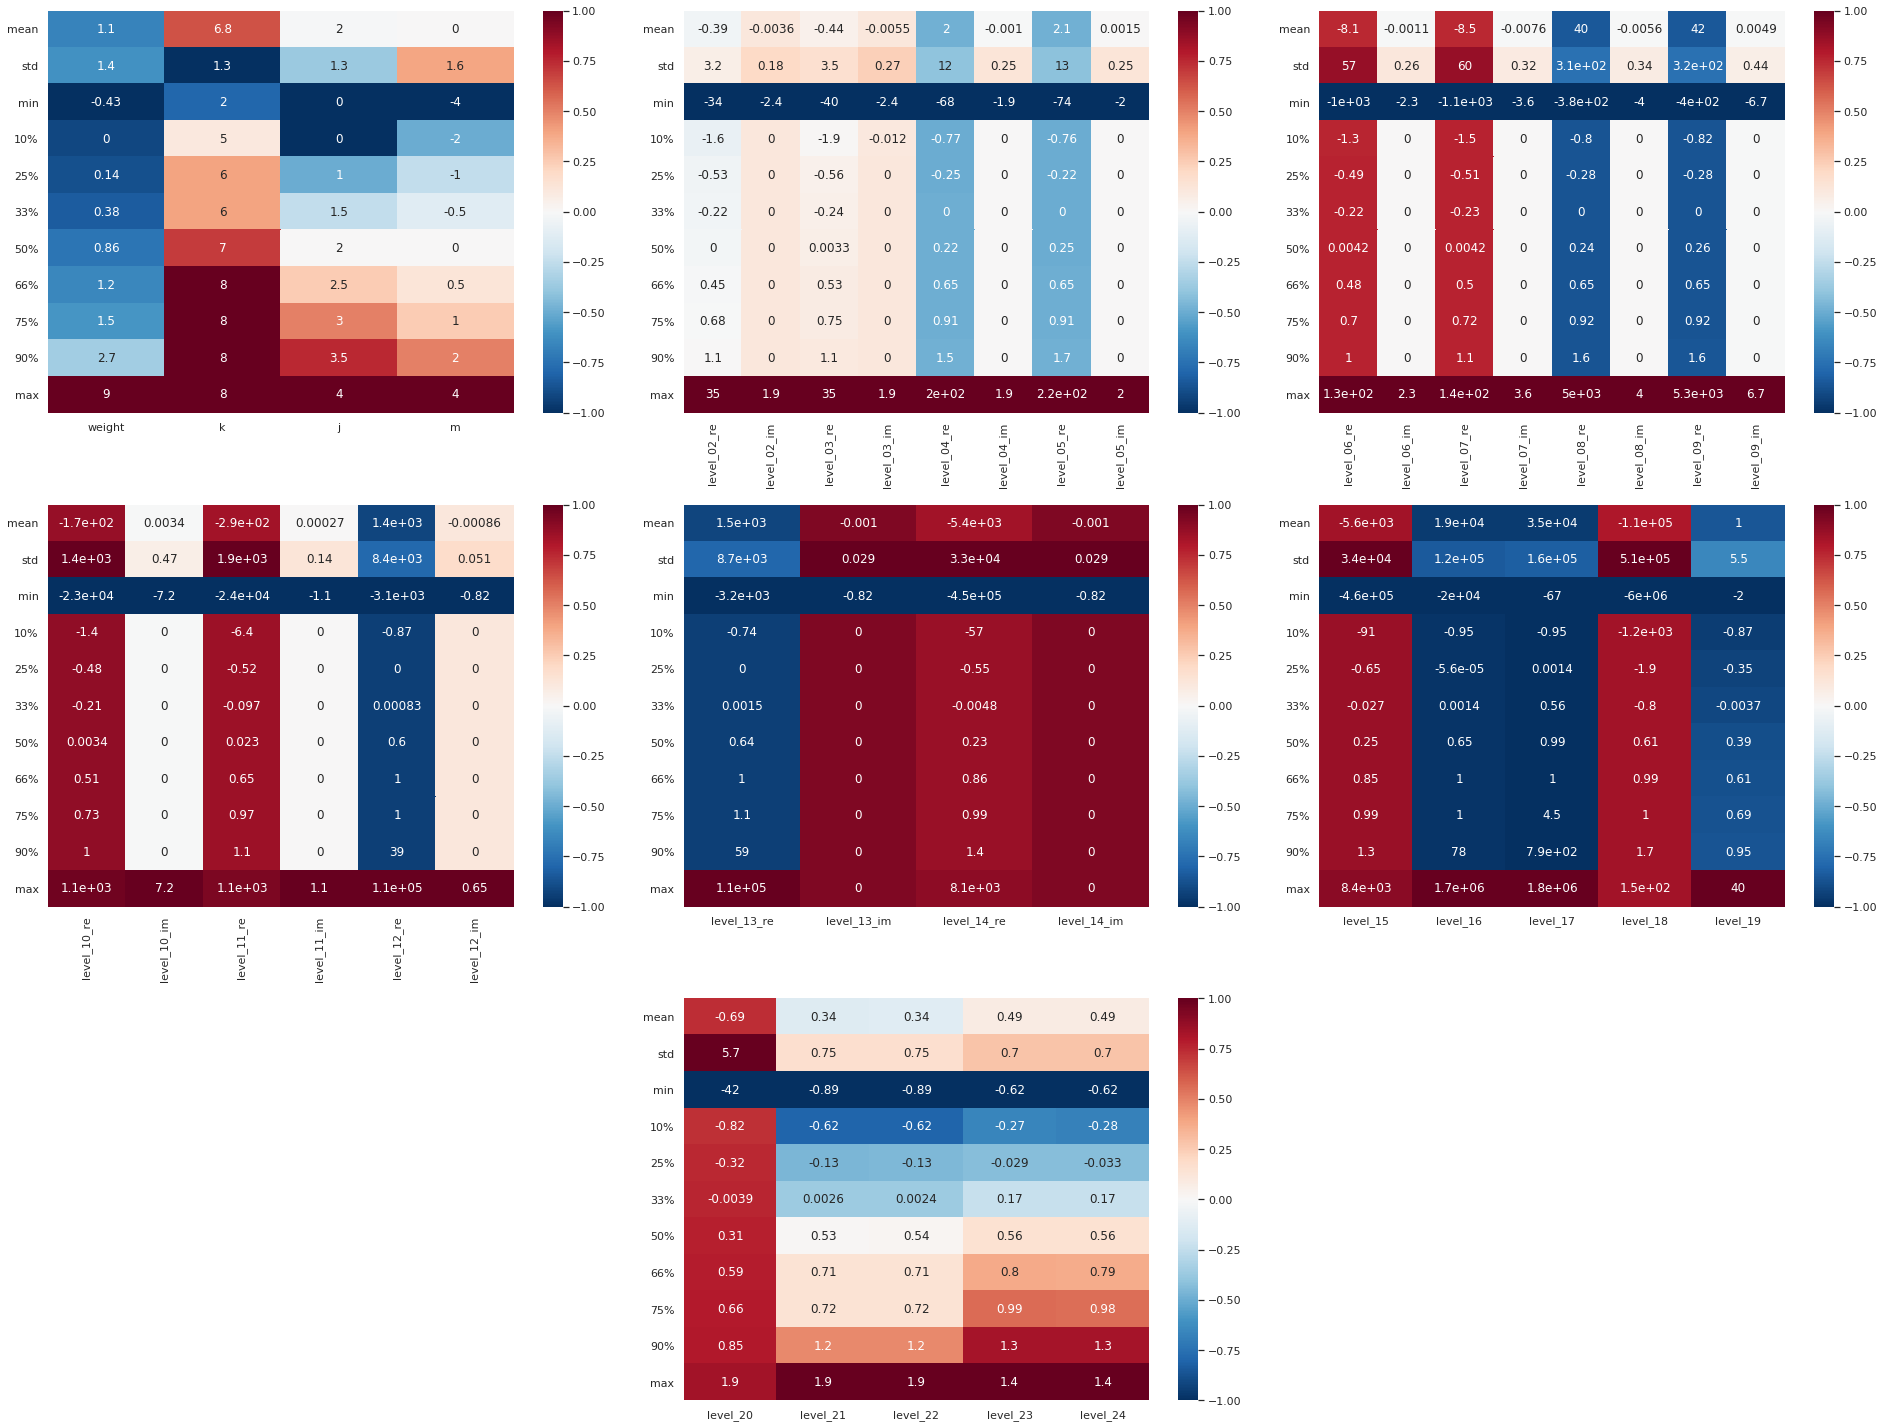

In [6]:
fig, ax = plt.subplots(3, 3, figsize=ratio(3,3))

sns.heatmap(df_stats_norm[['weight', 'k', 'j', 'm']],      annot=df_stats[['weight', 'k', 'j', 'm']],      cmap='RdBu_r', vmin=-1.0, vmax=1.0, center=0.0, ax=ax[0,0])
sns.heatmap(df_stats_norm.filter(regex='^level_0[2-5].*'), annot=df_stats.filter(regex='^level_0[2-5].*'), cmap='RdBu_r', vmin=-1.0, vmax=1.0, center=0.0, ax=ax[0,1])
sns.heatmap(df_stats_norm.filter(regex='^level_0[6-9].*'), annot=df_stats.filter(regex='^level_0[6-9].*'), cmap='RdBu_r', vmin=-1.0, vmax=1.0, center=0.0, ax=ax[0,2])
sns.heatmap(df_stats_norm.filter(regex='^level_1[0-2].*'), annot=df_stats.filter(regex='^level_1[0-2].*'), cmap='RdBu_r', vmin=-1.0, vmax=1.0, center=0.0, ax=ax[1,0])
sns.heatmap(df_stats_norm.filter(regex='^level_1[3-4].*'), annot=df_stats.filter(regex='^level_1[3-4].*'), cmap='RdBu_r', vmin=-1.0, vmax=1.0, center=0.0, ax=ax[1,1])
sns.heatmap(df_stats_norm.filter(regex='^level_1[5-9].*'), annot=df_stats.filter(regex='^level_1[5-9].*'), cmap='RdBu_r', vmin=-1.0, vmax=1.0, center=0.0, ax=ax[1,2])
sns.heatmap(df_stats_norm.filter(regex='^level_2.*'),      annot=df_stats.filter(regex='^level_2.*'),      cmap='RdBu_r', vmin=-1.0, vmax=1.0, center=0.0, ax=ax[2,1])

fig.delaxes(ax[2,0])
fig.delaxes(ax[2,2])
savefig('stats', fig, root='./img', show=True, save_pdf=True)

### Categories and Spread of the Data

We can then study the spread of the data divided into categories (i.e. the physical models). For this we fill the `NaN` and `<NA>` values with zeros and study boxplots, spreads, etc.

In [7]:
df = df.fillna(value=0)

We then substitute the numerical values of the model in the dataset with the appropriate strings:

In [8]:
json_url     = urllib.request.urlopen('https://riccardo.rigoletto.dynu.net/datasets/ml-sft/model_dict_reverse.json')
transl_model = json.loads(json_url.read())

# replace the values
df.loc[:, 'model'] = df['model'].astype(str).replace(transl_model)

We can for instance take a look at the spread of the truncation levels in several ways:

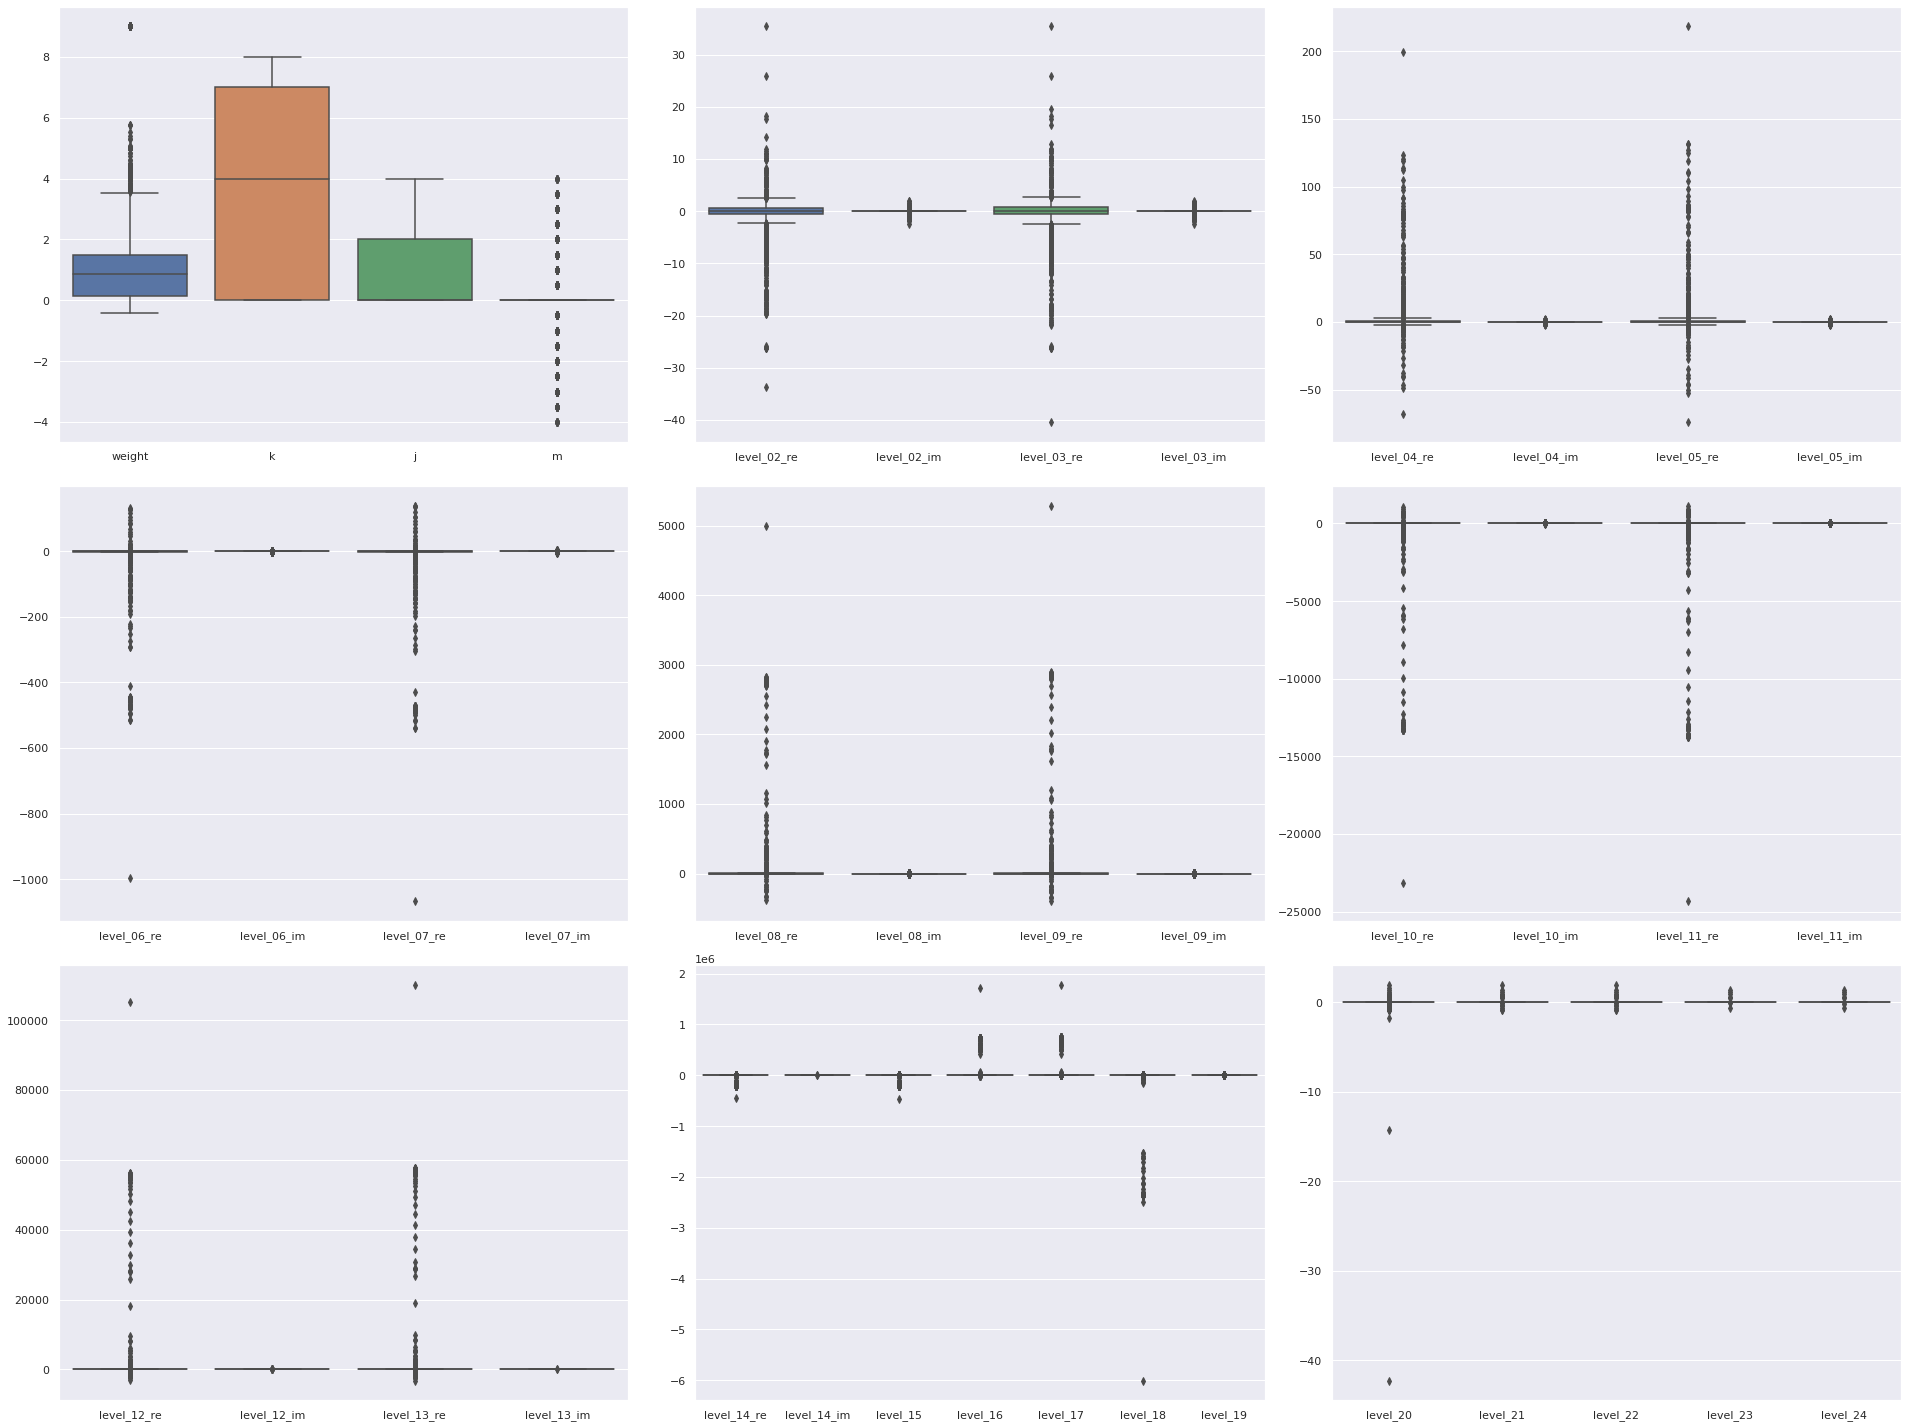

In [9]:
fig, ax = plt.subplots(3, 3, figsize=ratio(3,3))

sns.boxplot(data=df[['weight', 'k', 'j', 'm']],      ax=ax[0,0])
sns.boxplot(data=df.filter(regex='^level_0[2-3].*'), ax=ax[0,1])
sns.boxplot(data=df.filter(regex='^level_0[4-5].*'), ax=ax[0,2])
sns.boxplot(data=df.filter(regex='^level_0[6-7].*'), ax=ax[1,0])
sns.boxplot(data=df.filter(regex='^level_0[8-9].*'), ax=ax[1,1])
sns.boxplot(data=df.filter(regex='^level_1[0-1].*'), ax=ax[1,2])
sns.boxplot(data=df.filter(regex='^level_1[2-3].*'), ax=ax[2,0])
sns.boxplot(data=df.filter(regex='^level_1[4-9].*'), ax=ax[2,1])
sns.boxplot(data=df.filter(regex='^level_2.*'),      ax=ax[2,2])

savefig('distributions', fig, root='./img', show=True, save_pdf=True)

Distributions are heavily not Gaussians and usually present a narrow peak and spread outliers.

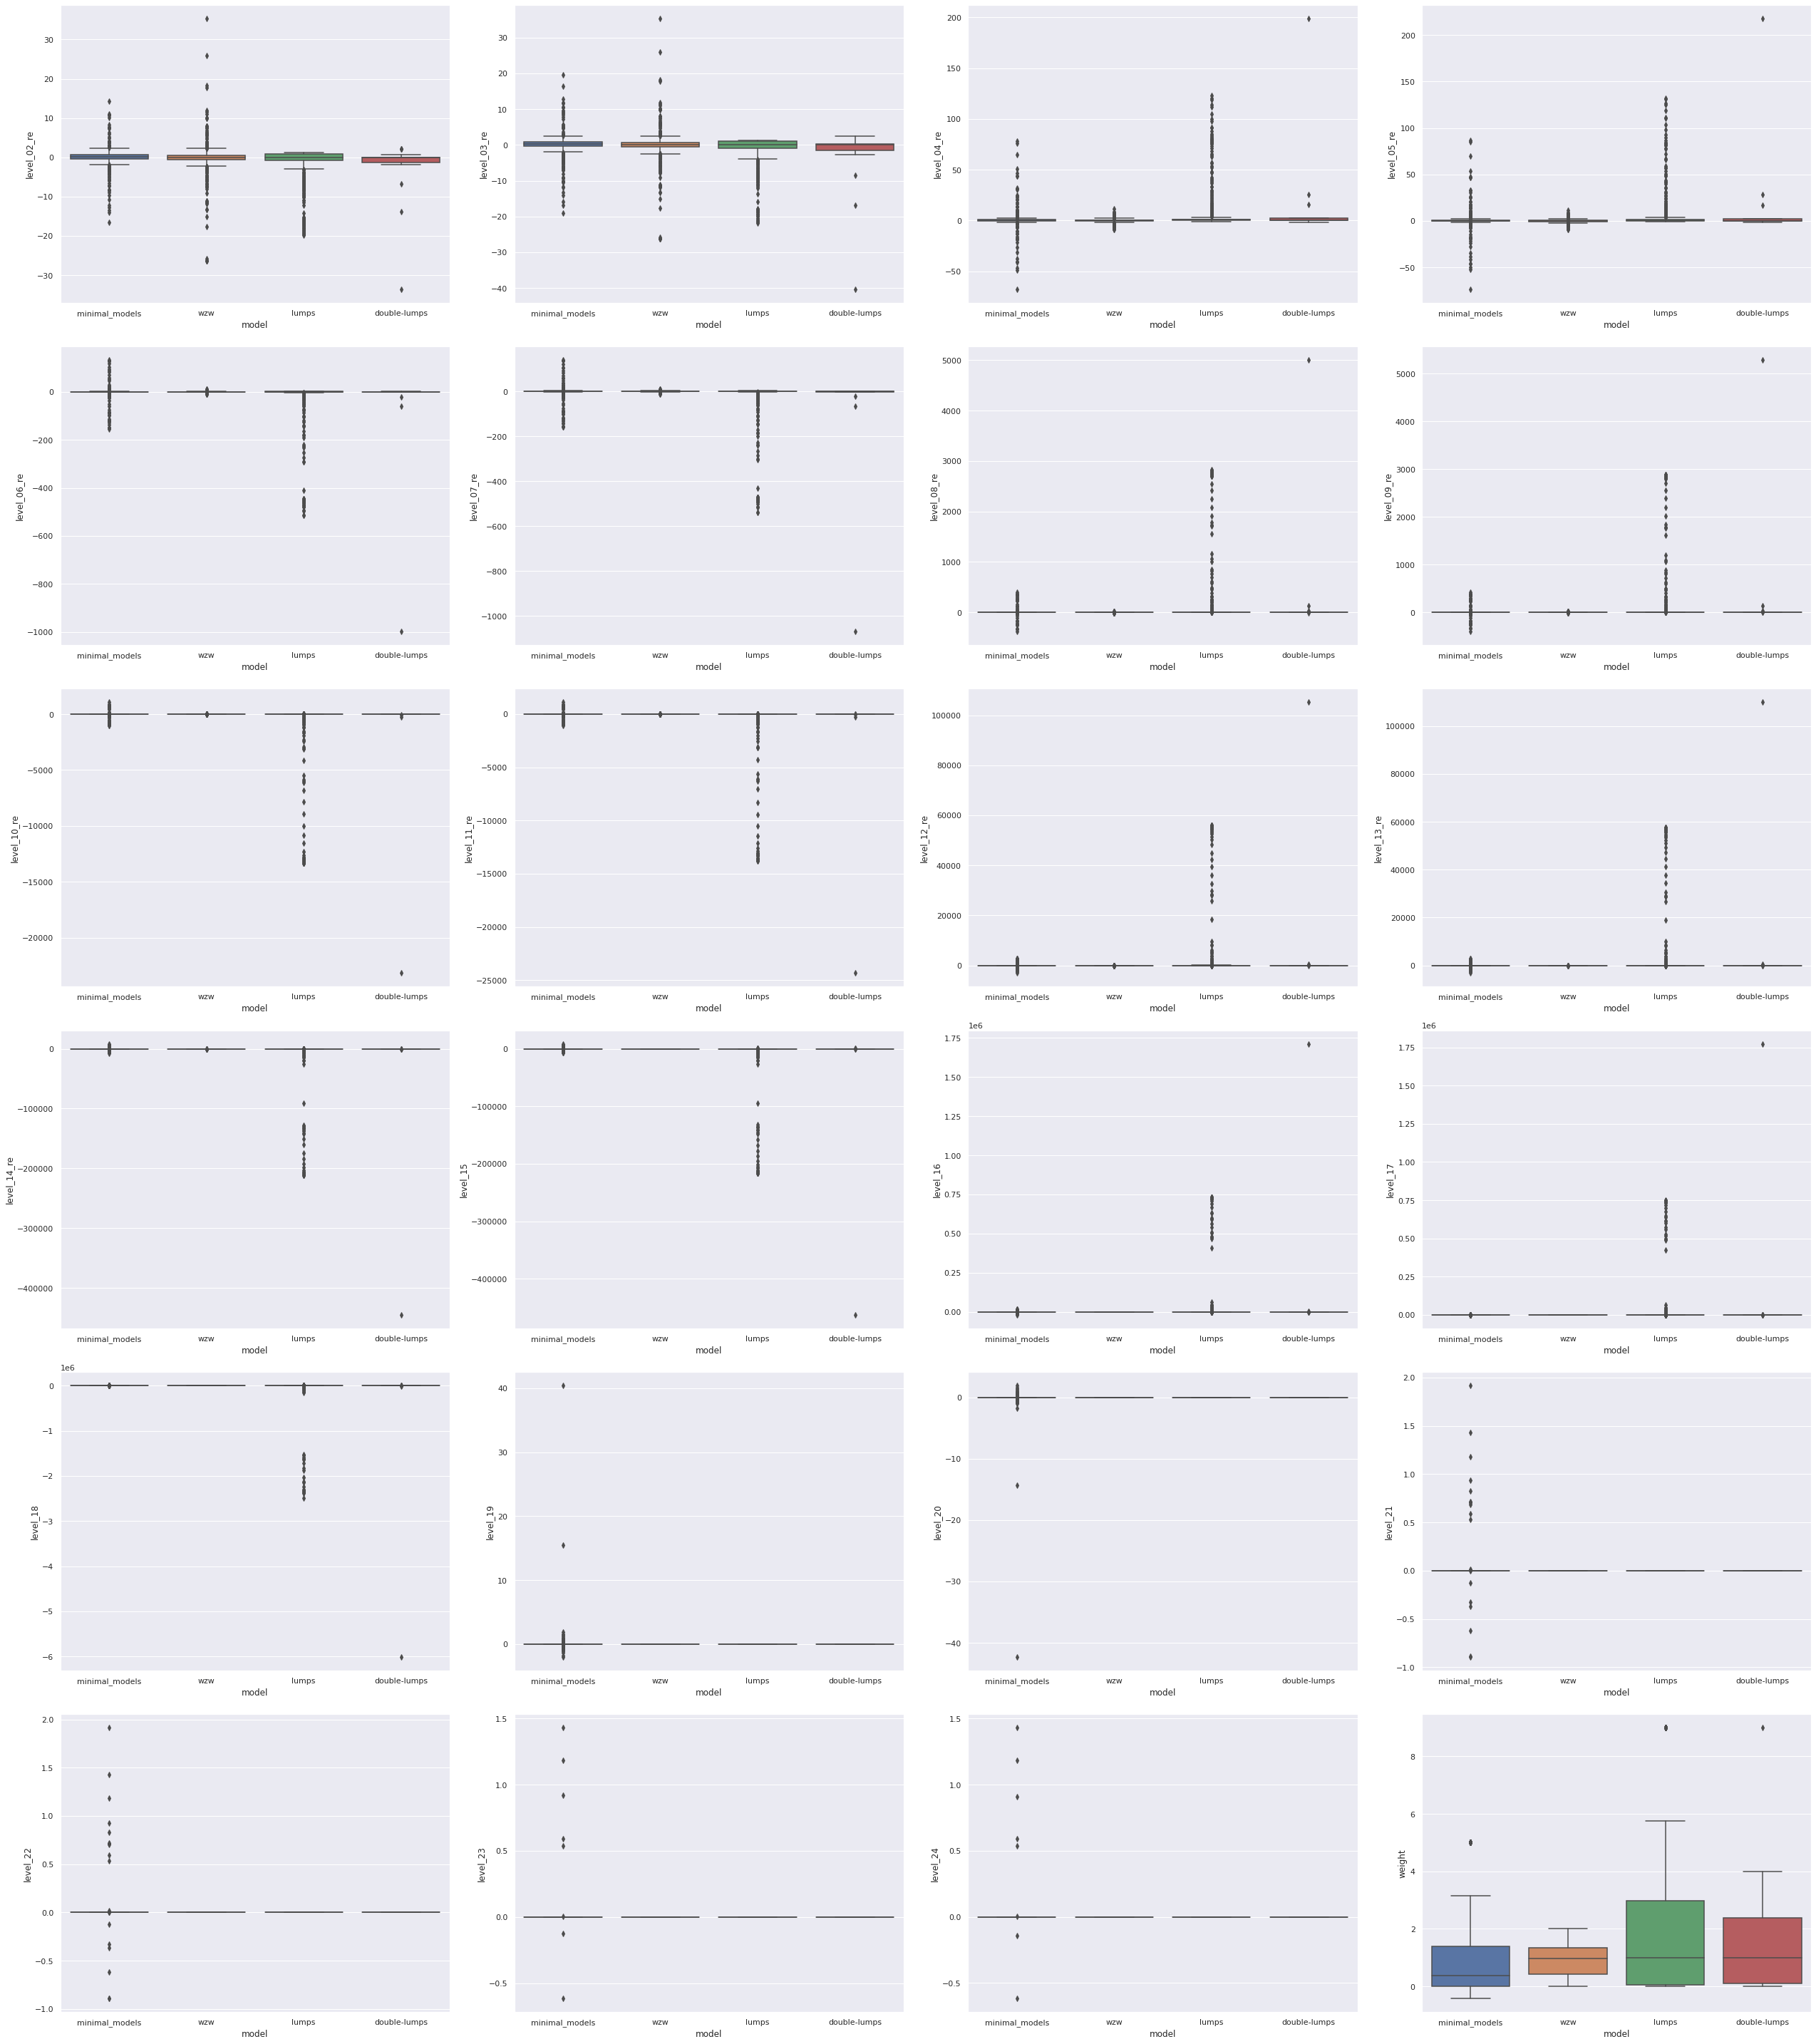

In [10]:
rows, cols = 6, 4
fig, ax = plt.subplots(rows, cols, figsize=ratio(cols,rows))

# plot the truncation levels and the weight
for n in range(2, 26):
    
    # plot the real part for level up to 15
    if n < 25:
        y = 'level_' + f'{n:02}'
        if n < 15:
            y += '_re'
    else:
        y = 'weight'
    
    sns.boxplot(data=df, x='model', y=y, ax=ax[(n - 2) // cols, (n - 2) % cols])

savefig('distribution_per_model', fig=fig, root='./img', show=True, save_pdf=True)

### Correlations and Notable Relations

We can also try to see if variables such as *weight*, or the first few levels vary between model and *type* of oscillation. This might be interesting in case the oscillation is correlated to the variables.

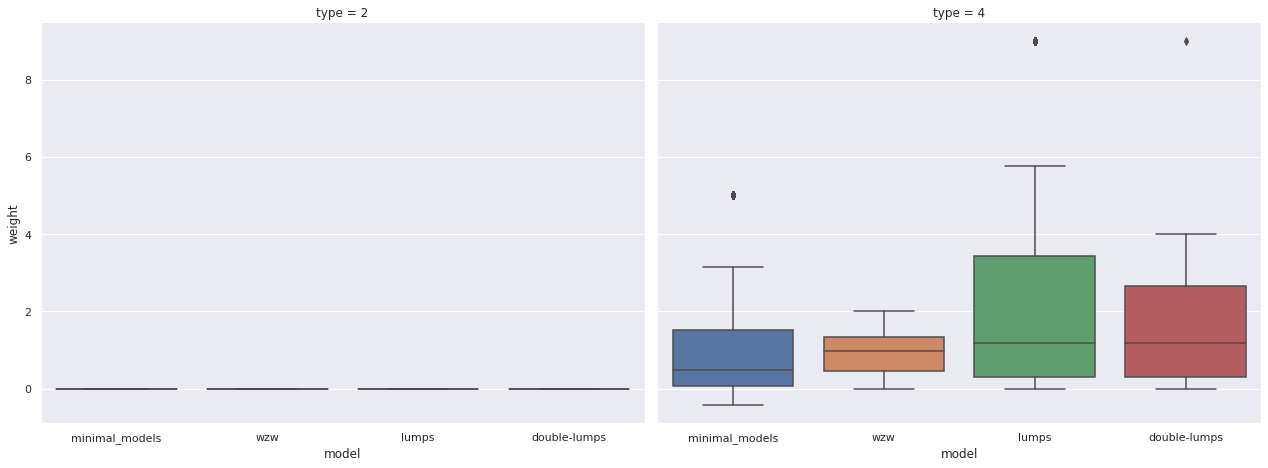

In [11]:
width, height = ratio(1, 1)

catplot = sns.catplot(data=df, x='model', y='weight', col='type', kind='box', sharey=True, height=height, aspect=width / height)

catplot.tight_layout()
catplot.savefig('./img/weight_distribution.pdf', format='pdf', dpi=72)

It seems that the *type* of oscillation has a direct consequence on the weight. In particular $\text{type} = 2 \Rightarrow h = 0$:

In [12]:
df[['weight', 'model', 'type']].groupby(['model', 'type']).describe()

weight                                                    \
                      count      mean       std       min       25%       50%   
model          type                                                             
double-lumps   2        2.0  0.000000  0.000000  0.000000  0.000000  0.000000   
               4       18.0  1.905864  2.229810  0.000000  0.298611  1.180556   
lumps          2       90.0  0.000000  0.000000  0.000000  0.000000  0.000000   
               4      673.0  2.114191  2.355165  0.000000  0.288906  1.190083   
minimal_models 2      130.0  0.000000  0.000000  0.000000  0.000000  0.000000   
               4      707.0  1.021598  1.298997 -0.428571  0.066667  0.476190   
wzw            2       92.0  0.000000  0.000000  0.000000  0.000000  0.000000   
               4     1588.0  0.956707  0.562849  0.000000  0.468750  0.972222   

                                    
                          75%  max  
model          type                 
double-lumps   2     0.000000  0.0  
               4     2.645833  9.0  
lumps          2     0.000000  0.0  
               4     3.422500  9.0  
minimal_models 2     0.000000  0.0  
               4     1.517857  5.0  
wzw            2     0.000000  0.0  
               4     1.333333  2.0

We can then study in the same way how the first few levels and the last are distributed:

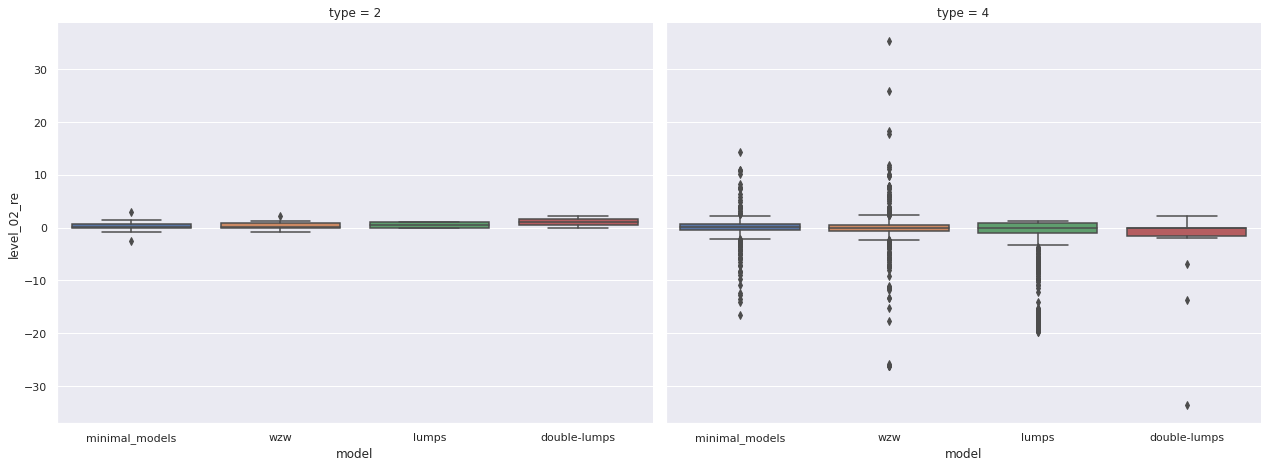

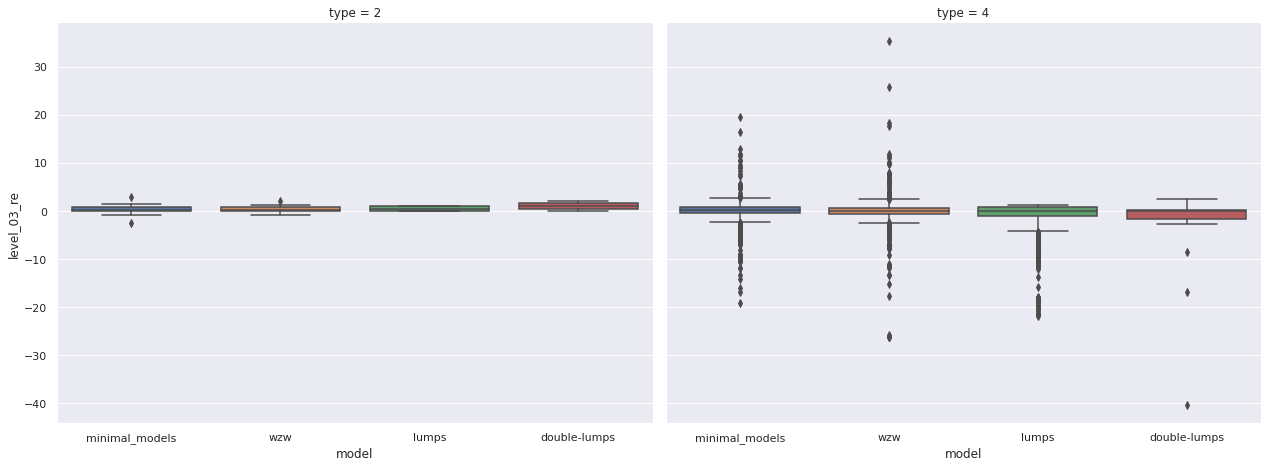

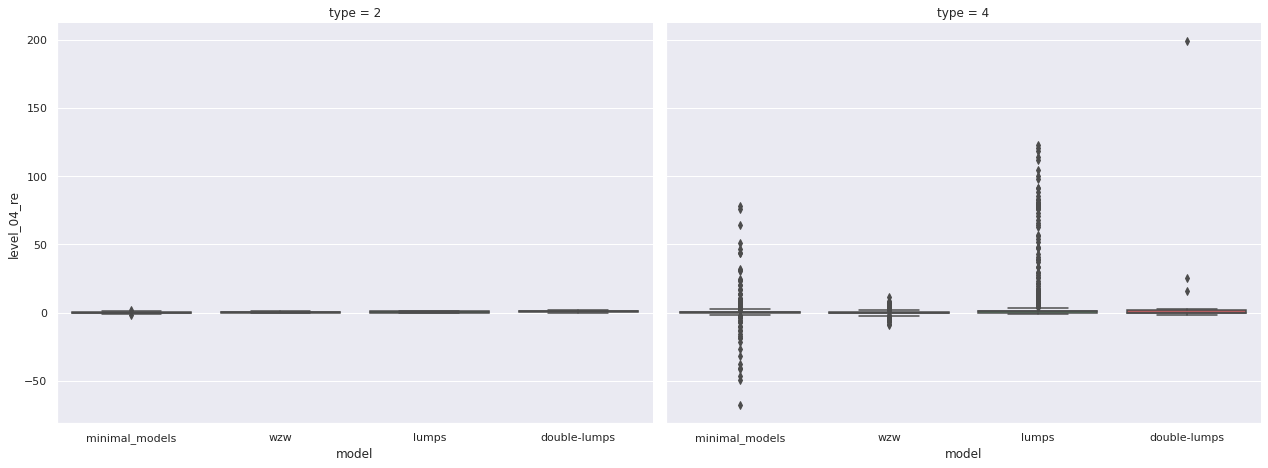

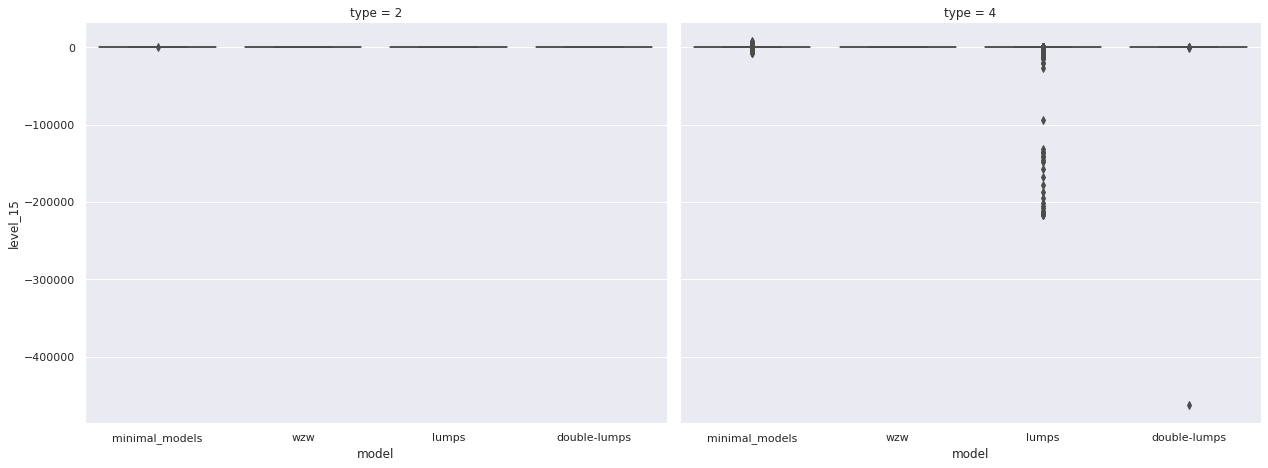

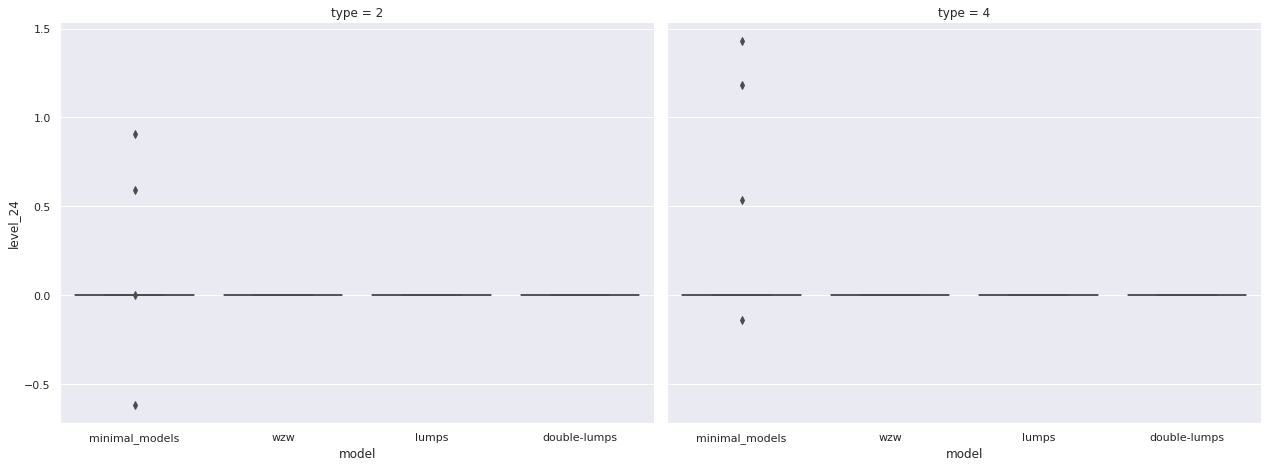

In [13]:
width, height = ratio(1, 1)

for level in ['level_02_re', 'level_03_re', 'level_04_re', 'level_15', 'level_24']:
    
    catplot = sns.catplot(data=df, x='model', y=level, col='type', kind='box', sharey=True, height=height, aspect=width / height)

    catplot.tight_layout()
    catplot.savefig('./img/' + level + '_distribution.pdf', format='pdf', dpi=72)

For the first few levels, the distribution of the data presents more outliers when $\text{type} = 4$. However this might also be related to the different values of the *weight*, which are correlated to the *type* of the oscillation.

In [14]:
df['weight_bin'] = pd.cut(df['weight'], bins=[np.floor(df['weight'].min()), 0.0, 1.0, 2.0, 5.0, np.ceil(df['weight'].max()) + 1], right=False, include_lowest=True)

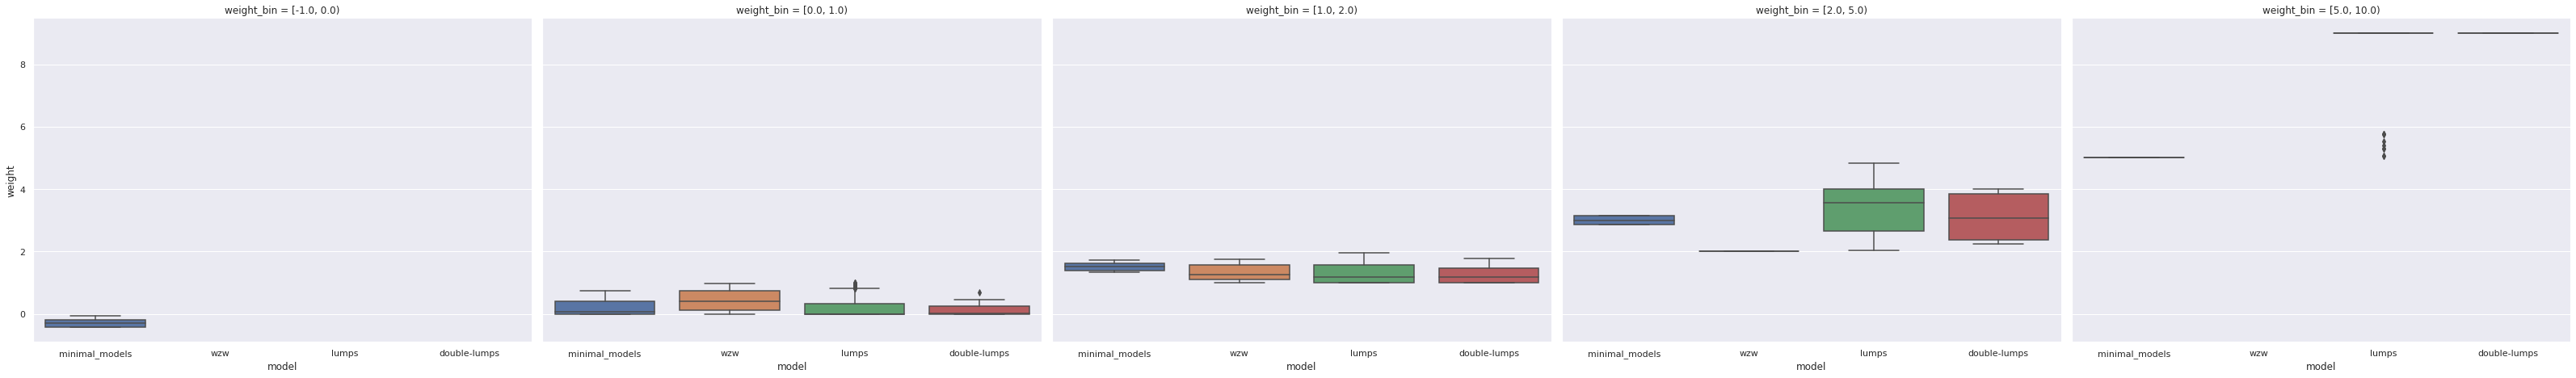

In [15]:
width, height = ratio(1, 1)

catplot = sns.catplot(data=df, x='model', y='weight', col='weight_bin', kind='box', sharey=True, height=height, aspect=width / height)

catplot.tight_layout()
catplot.savefig('./img/weight_distribution_binned.pdf', format='pdf', dpi=72)

From the plots is also seems that the WZW model does not have high conformal weights:

In [16]:
df[['weight', 'model']].groupby(['model']).agg(['min', 'max'])

weight     
                     min  max
model                        
double-lumps    0.000000  9.0
lumps           0.000000  9.0
minimal_models -0.428571  5.0
wzw             0.000000  2.0

The highest weight for the WZW model is in fact $2$. In the same way we notice that the minimal models only get up to $5$ in *weight*.

We can then take a look at the spread of the truncation levels for various values of the *weight* variable.

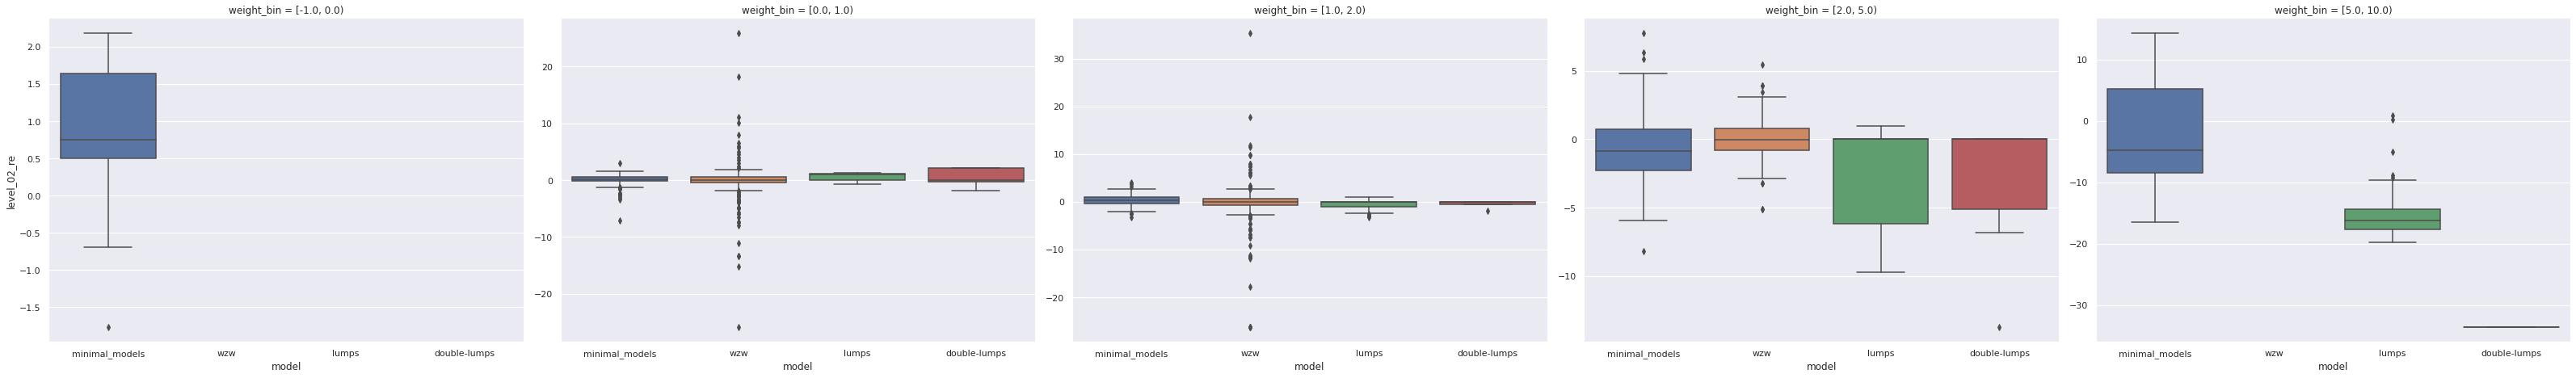

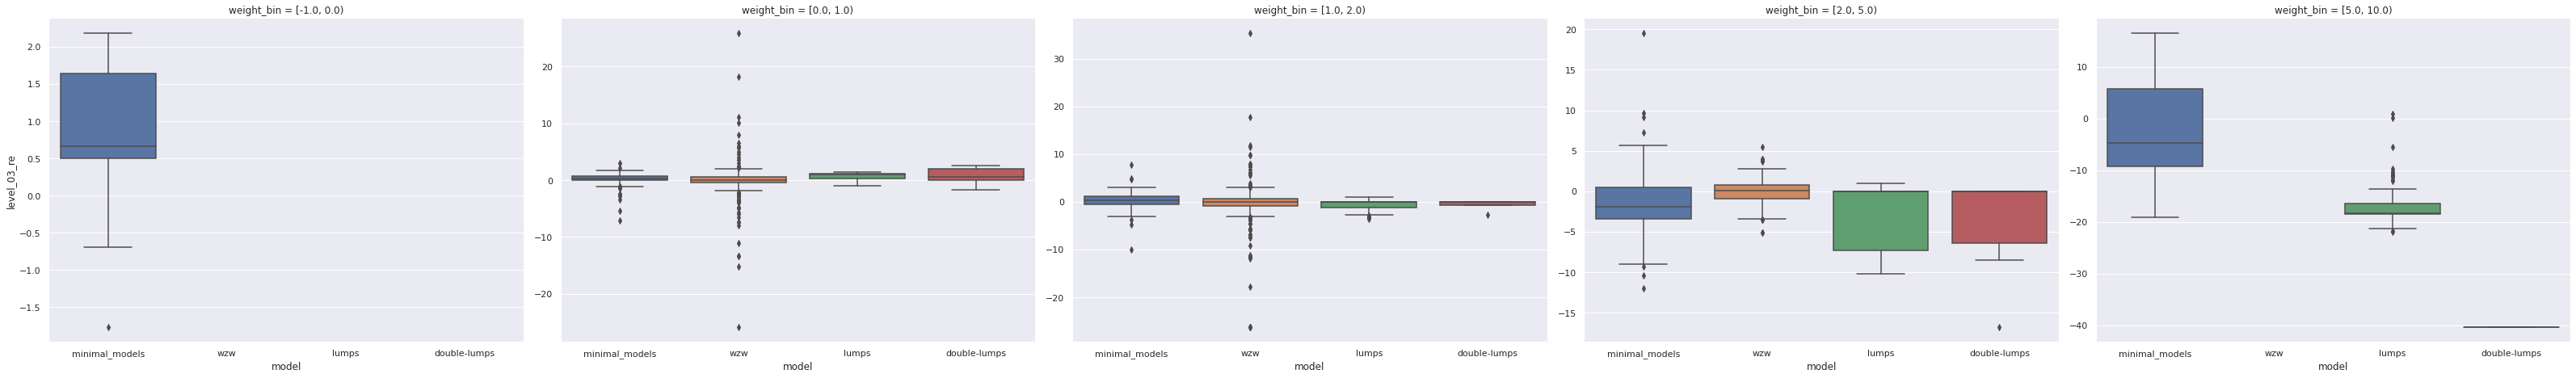

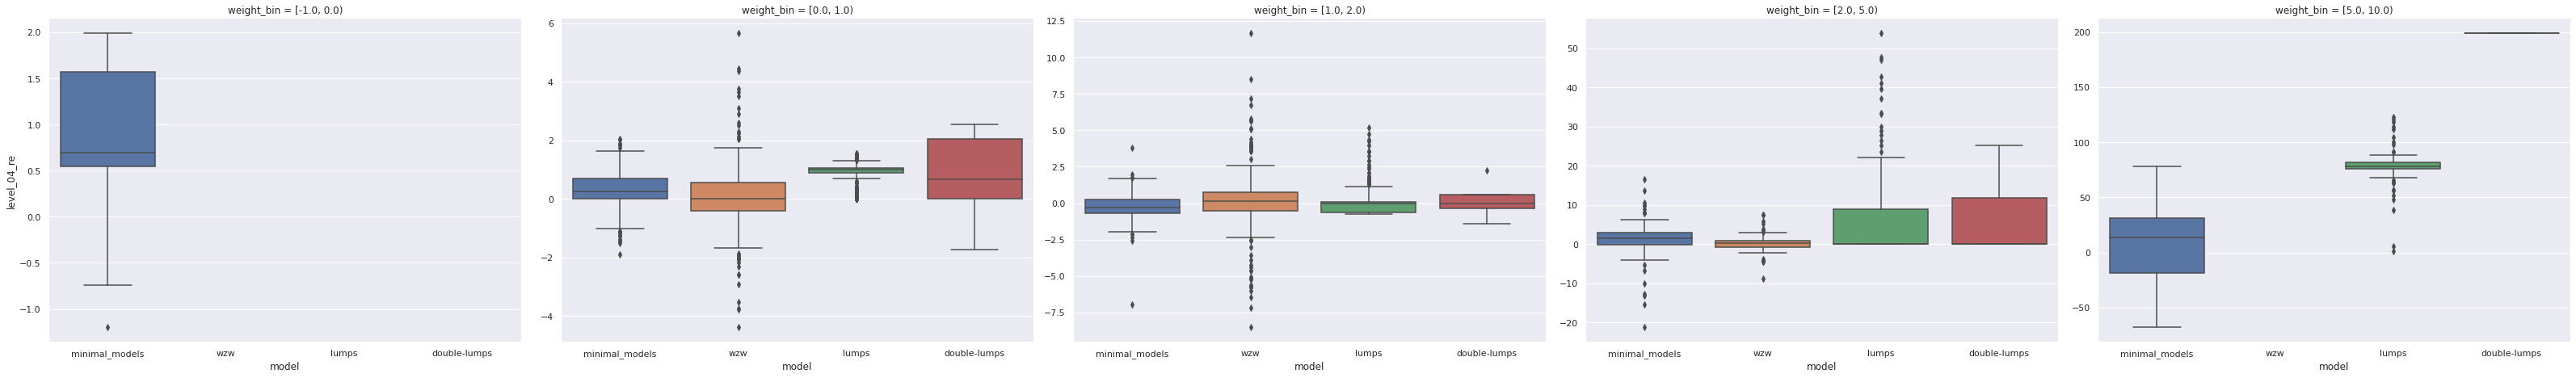

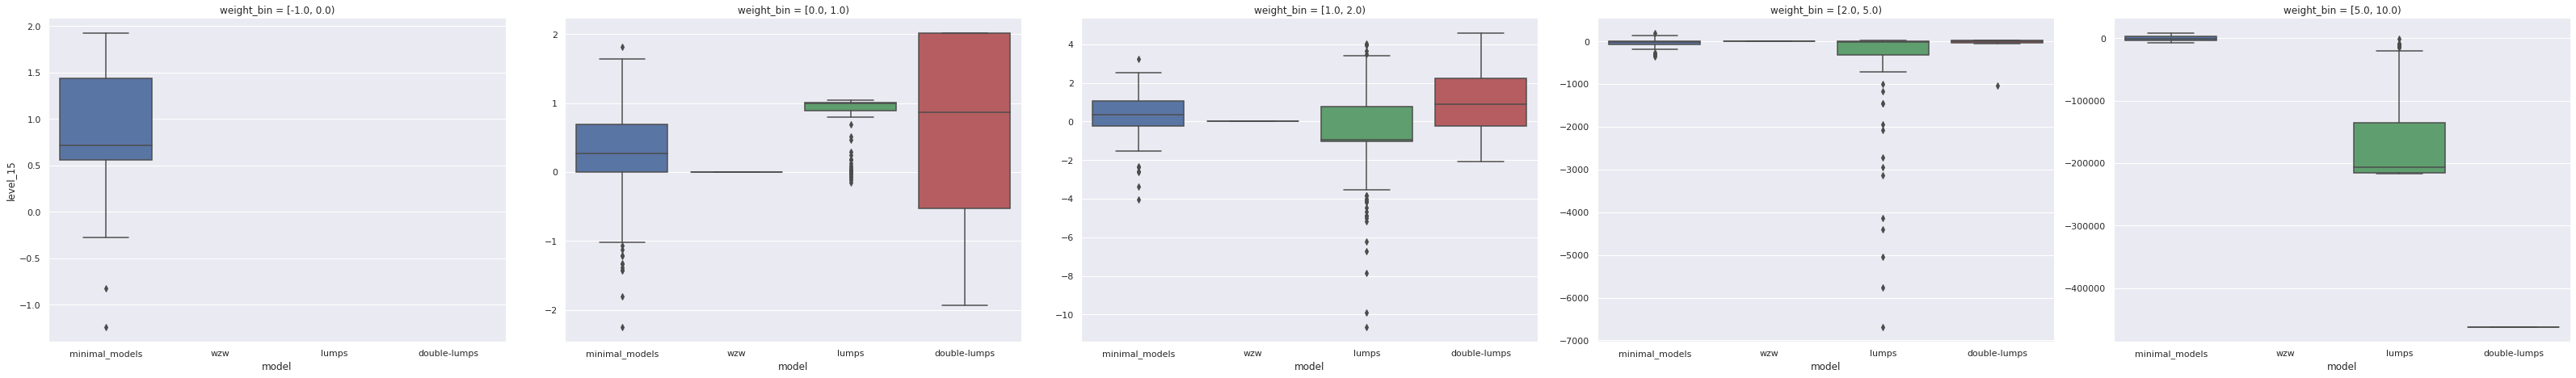

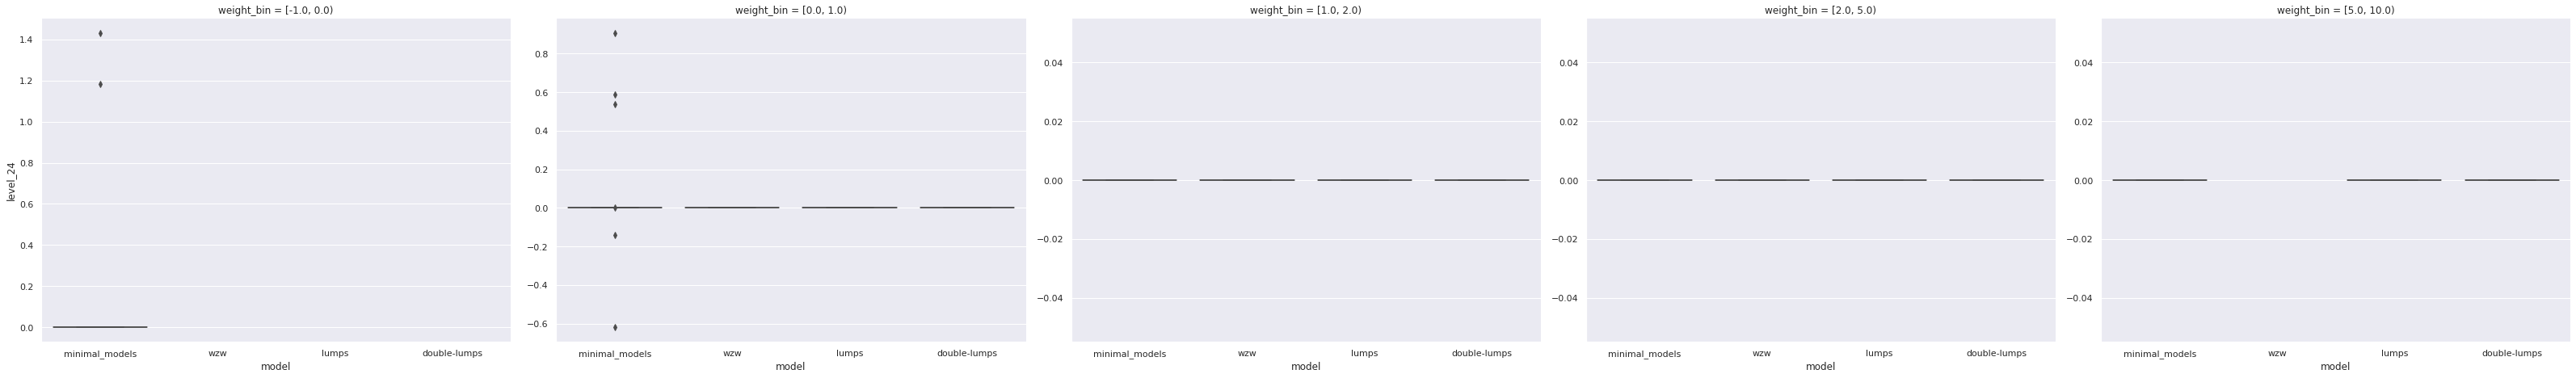

In [17]:
width, height = ratio(1, 1)

for level in ['level_02_re', 'level_03_re', 'level_04_re', 'level_15', 'level_24']:
    
    catplot = sns.catplot(data=df, x='model', y=level, col='weight_bin', kind='box', sharey=False, height=height, aspect=width / height)

    catplot.tight_layout()
    catplot.savefig('./img/' + level + '_distribution_binned.pdf', format='pdf', dpi=72)

As expected only non unitary, minimal models have negative weights. The variance of the data looks to be connected the various factors:

- **higher truncation levels** usually present higher variance,
- the **WZW model** presents a narrowly peaked distribution with outliers,
- **higher weight** usually presents higher variance.

In general values are not i.i.d. This suggests that usual strategies may not be usable here. 

## Model Classification

In order to simplify the analysis we would like to test whether it is possible to classify data in the correspondent model (*minimal*, *WZW*, *lumps*, *double lumps*) using data such as *weight*, *type*, and the first few truncation level (which we assume they can always be computed).

We try to use two different approaches:

- **clusterization** to test whether there is a structure in the data which can be used to assign an observable to a model,
- supervised **classification** to test whether the model can be inferred from the data.

In [18]:
random_state = 123


splits = {'train_split': 0.8, 'val_split': 0.5}
(df_train, df_val, df_test), (n_train, n_val, n_test) = train_test(df, splits, random_state=random_state)

print(f'Training samples:   {n_train:d} ({100 * n_train / n_rows:.2f}%)')
print(f'Validation samples: {n_val:d} ({100 * n_val / n_rows:.2f}%)')
print(f'Test samples:       {n_test:d} ({100 * n_test / n_rows:.2f}%)')

Training samples:   2640 (80.00%)
Validation samples: 330 (10.00%)
Test samples:       330 (10.00%)


In [19]:
# create the saving directory
os.makedirs('./models', exist_ok=True)

### Clusterization

We investigate the possibility to form clusters using *KMeans* . Since we know, at the moment, the ground truth values, we evaluate the assignment using **homogeneity** and **completeness**. Namely we look for two objectives (see https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation):

- **homogeneity**: each cluster contains only members of a single class,
- **completeness**: all members of a given class are assigned to the same cluster.

In particular we study **homogeneity** alone to test the feasibility of the approach (even if a single class is represented by two different clusters, in principle this could still be a good clusterization). However, we consider the **v-score** (i.e. the harmonic mean of homogeneity and completeness) to test how the clusterization is exclusive in terms of separating the models.

In [20]:
# define the columns to keep (remove if needed)
columns = [column for column in df.columns if bool(re.match(f'^weight$|^type$|^level.*|^k$|^j$|^m$', column))]

# define grid searches
kmeans_grid = {'n_clusters':  [4, 5, 6, 7, 8, 9, 10]}

# grid creation
kmeans_grid = ParameterGrid(kmeans_grid)
best_estimator = lambda evaluations: np.argmax(evaluations['v_score'])

In [21]:
# evaluation of KMeans
kmeans        = lambda param: cluster.KMeans(random_state=random_state, **param).fit(df_train[columns])
kmeans_fitted = Parallel(n_jobs=-1)(delayed(kmeans)(param) for param in kmeans_grid)

kmeans_eval   = {'parameters': list(kmeans_grid),
                 'v_score':    [metrics.v_measure_score(df_val['model'], k.predict(df_val[columns])) for k in kmeans_fitted],
                 'h_score':    [metrics.homogeneity_score(df_val['model'], k.predict(df_val[columns])) for k in kmeans_fitted],
                 'c_score':    [metrics.completeness_score(df_val['model'], k.predict(df_val[columns])) for k in kmeans_fitted]
                }

best_kmeans_pos          = best_estimator(kmeans_eval)
best_kmeans              = {key: score[best_kmeans_pos] for key, score in kmeans_eval.items()}
best_kmeans['estimator'] = kmeans_fitted[best_kmeans_pos]

# KMeans predictions
kmeans_test_pred = best_kmeans['estimator'].predict(df_test[columns])
kmeans_test      = {'v_score': metrics.v_measure_score(df_test['model'], kmeans_test_pred),
                    'h_score': metrics.homogeneity_score(df_test['model'], kmeans_test_pred),
                    'c_score': metrics.completeness_score(df_test['model'], kmeans_test_pred)
                   }

print('KMeans clustering:')
print(f'  Best parameters:                  {best_kmeans["parameters"]}')
print(f'  Best V score (validation):        {best_kmeans["v_score"]:.4f}')
print(f'  Homogeneity score (validation):   {best_kmeans["h_score"]:.4f}')
print(f'  Completeness score (validation):  {best_kmeans["c_score"]:.4f}')
print(f'  V score (predictions):            {kmeans_test["v_score"]:.4f}')
print(f'  Homogeneity score (predictions):  {kmeans_test["h_score"]:.4f}')
print(f'  Completeness score (predictions): {kmeans_test["c_score"]:.4f}')

KMeans clustering:
  Best parameters:                  {'n_clusters': 4}
  Best V score (validation):        0.0255
  Homogeneity score (validation):   0.0134
  Completeness score (validation):  0.2629
  V score (predictions):            0.0357
  Homogeneity score (predictions):  0.0193
  Completeness score (predictions): 0.2418


It seems that there is no possibility to find suitable clusters to distinguish the models.

### Supervised Classification

We then consider a function approximator to classify the models. We use a simple neural network to match the *one-hot encoded* labels of the models.

In [22]:
# set random seed
tf.random.set_seed(random_state)

# select columns
columns = [column for column in df.columns if bool(re.match(f'^weight$|^type$|^level.*|^k$|^j$|^m$', column))]

# one-hot encoding
df_train_class = pd.get_dummies(df_train, columns=['model'])
df_val_class   = pd.get_dummies(df_val, columns=['model'])
df_test_class  = pd.get_dummies(df_test, columns=['model'])

# features and labels
X_train_class           = df_train_class[columns]
X_train_class_lstm_conv = X_train_class.filter(regex='^level.*re$|^level_1[5-9].*|^level_2.*')
X_train_class_lstm_conv = X_train_class_lstm_conv.values.reshape(X_train_class_lstm_conv.shape + (1,))
y_train_class           = df_train_class.filter(regex='^model.*')
y_train_class_conv      = y_train_class.values.reshape(-1, 1, y_train_class.shape[1])

X_val_class             = df_val_class[columns]
X_val_class_lstm_conv   = X_val_class.filter(regex='^level.*re$|^level_1[5-9].*|^level_2.*')
X_val_class_lstm_conv   = X_val_class_lstm_conv.values.reshape(X_val_class_lstm_conv.shape + (1,))
y_val_class             = df_val_class.filter(regex='^model.*')
y_val_class_conv        = y_val_class.values.reshape(-1, 1, y_val_class.shape[1])

X_test_class            = df_test_class[columns]
X_test_class_lstm_conv  = X_test_class.filter(regex='^level.*re$|^level_1[5-9].*|^level_2.*')
X_test_class_lstm_conv  = X_test_class_lstm_conv.values.reshape(X_test_class_lstm_conv.shape + (1,))
y_test_class            = df_test_class.filter(regex='^model.*')
y_test_class_conv       = y_test_class.values.reshape(-1, 1, y_test_class.shape[1])

We use different models created using the Keras API:

In [23]:
# create models
models = {'simple_dense':  keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=X_train_class.shape[1:]),
                                             keras.layers.Dense(64, activation='relu'),
                                             keras.layers.Dense(32, activation='relu'),
                                             keras.layers.Dense(y_train_class.shape[1], activation='softmax')
                                            ],
                                            name='simple_dense'
                                           ),
          'bnorm_dense':   keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=X_train_class.shape[1:]),
                                             keras.layers.Dense(64, activation='relu'),
                                             keras.layers.BatchNormalization(),
                                             keras.layers.Dense(32, activation='relu'),
                                             keras.layers.BatchNormalization(),
                                             keras.layers.Dense(y_train_class.shape[1], activation='softmax')
                                            ],
                                            name='bnorm_dense'
                                           ),
          'simple_conv1d': keras.Sequential([keras.layers.Conv1D(128, kernel_size=3, strides=2, padding='valid', activation='relu', input_shape=X_train_class_lstm_conv.shape[1:]),
                                             keras.layers.Conv1D(128, kernel_size=3, strides=2, padding='valid', activation='relu'),
                                             keras.layers.Conv1D(64, kernel_size=3, padding='valid', activation='relu'),
                                             keras.layers.Conv1D(32, kernel_size=2, padding='valid', activation='relu'),
                                             keras.layers.Conv1D(4, kernel_size=2, padding='valid', activation='softmax'),
                                            ],
                                            name='simple_conv1d'
                                           ),
          'bnorm_conv1d':  keras.Sequential([keras.layers.Conv1D(128, kernel_size=3, strides=2, padding='valid', activation='relu', input_shape=X_train_class_lstm_conv.shape[1:]),
                                             keras.layers.Conv1D(128, kernel_size=3, strides=2, padding='valid', activation='relu'),
                                             keras.layers.Conv1D(64, kernel_size=3, padding='valid', activation='relu'),
                                             keras.layers.BatchNormalization(),
                                             keras.layers.Conv1D(32, kernel_size=2, padding='valid', activation='relu'),
                                             keras.layers.BatchNormalization(),
                                             keras.layers.Conv1D(4, kernel_size=2, padding='valid', activation='softmax'),
                                            ],
                                            name='bnorm_conv1d'
                                           ),
          'simple_lstm':   keras.Sequential([keras.layers.LSTM(128, input_shape=X_train_class_lstm_conv.shape[1:], return_sequences=True),
                                             keras.layers.LSTM(64, input_shape=X_train_class_lstm_conv.shape[1:], return_sequences=True),
                                             keras.layers.LSTM(32, input_shape=X_train_class_lstm_conv.shape[1:], return_sequences=True),
                                             keras.layers.LSTM(32, input_shape=X_train_class_lstm_conv.shape[1:], return_sequences=True),
                                             keras.layers.LSTM(16, input_shape=X_train_class_lstm_conv.shape[1:], return_sequences=False),
                                             keras.layers.Dense(4, activation='softmax')
                                            ],
                                            name='simple_lstm'
                                           )
         }

# define a translation dictionary for the names of the models
models_dict = {'simple_dense':  'Fully Connected Model (w/o batch normalization)',
               'bnorm_dense':   'Fully Connected Model (w/ batch normalization)',
               'simple_conv1d': 'Purely Convolutional Network (w/o batch normalization)',
               'bnorm_conv1d':  'Purely Convolutional Network (w/ batch normalization)',
               'simple_lstm':   'LSTM Network',
              }

We then build the models using the *Adam* optimizer:

In [24]:
# define the learning rate
learning_rate = 1.0e-4
lr_reduction  = 0.3
lr_patience   = 1500
epochs        = 10000
summary_print = 1000

# compile the models
for name, model in models.items():
    
    # print the name of the model and the count of parameters
    print('_______________________________________________________________________')
    print(f'\nModel: {name} --> no. of parameters: {model.count_params()}')
    print('=======================================================================')
    
    # compile the model
    print(f'  Compiling with Adam (learning rate: {learning_rate:.4f})')
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=keras.losses.CategoricalCrossentropy(),
                  metrics=[keras.metrics.CategoricalAccuracy()]
                 )
    
    # create the callbacks
    print(f'  Creating saving checkpoints...')
    os.makedirs(os.path.join('./models', name), exist_ok=True)
    
    callbacks = model_checkpoints(root=os.path.join('./models', name), reduce_lr=lr_reduction, lr_patience=lr_patience, summary=summary_print)
    
    # print summary
    strings = []
    model.summary(line_length=78, print_fn=lambda s: strings.append(s))                               # keras summary
    strings.append(f'==============================================================================') # separator
    strings.append(f'Training: {epochs:d} epochs')                                                    # no. of epochs
    strings.append(f'Initial learning rate: {learning_rate:.4f} (Adam optimizer)')                    # initial lr
    strings.append(f'Learning rate reduction: {lr_reduction:.2f} after {lr_patience:d} epochs')       # lr reduction
    strings.append(f'______________________________________________________________________________') # separator
    short_summary = '\n'.join(strings)
    
    with open(os.path.join('./models', name, 'summary.txt'), 'w') as f:
        f.write(short_summary)
        
    # fit the model
    print('  Fitting the model...\n')
    if bool(re.match('.*_dense', name)):
        
        history = model.fit(x=X_train_class,
                            y=y_train_class,
                            batch_size=32,
                            epochs=epochs,
                            verbose=0,
                            callbacks=callbacks,
                            validation_data=(X_val_class, y_val_class)
                           )
        
    if bool(re.match('.*_conv1d', name)):
        
        history = model.fit(x=X_train_class_lstm_conv,
                            y=y_train_class_conv,
                            batch_size=32,
                            epochs=epochs,
                            verbose=0,
                            callbacks=callbacks,
                            validation_data=(X_val_class_lstm_conv, y_val_class_conv)
                           )
        
    if bool(re.match('.*_lstm', name)):
        
        history = model.fit(x=X_train_class_lstm_conv,
                            y=y_train_class,
                            batch_size=32,
                            epochs=epochs,
                            verbose=0,
                            callbacks=callbacks,
                            validation_data=(X_val_class_lstm_conv, y_val_class)
                           )
        
    # reload best weights and save the history
    model = keras.models.load_model(os.path.join('./models', name, 'val_loss.h5'))
    
    # convert history to correct arrays
    dump(history.history, os.path.join('./models', name, 'history.joblib.gz'))

_______________________________________________________________________

Model: simple_dense --> no. of parameters: 15844
  Compiling with Adam (learning rate: 0.0001)
  Creating saving checkpoints...
  Fitting the model...

Training has started. Callouts will be printed every 1000 epochs.

Training epoch 1. Started on 31/12/2020 at 16:55:25.

    Average epoch training time: 00 hours, 00 minutes, 00 seconds

    loss = 5545.617676
    categorical_accuracy = 0.542045
    val_loss = 232.596786
    val_categorical_accuracy = 0.824242
    lr = 0.000100

Training epoch 1000. Started on 31/12/2020 at 16:57:14.

    Average epoch training time: 00 hours, 00 minutes, 00 seconds

    loss = 1.400282
    categorical_accuracy = 0.984470
    val_loss = 0.108475
    val_categorical_accuracy = 0.969697
    lr = 0.000100

Training epoch 2000. Started on 31/12/2020 at 16:59:02.

    Average epoch training time: 00 hours, 00 minutes, 00 seconds

    loss = 0.022460
    categorical_accuracy = 0.990152


For each model we can plot its loss function and its accuracy:

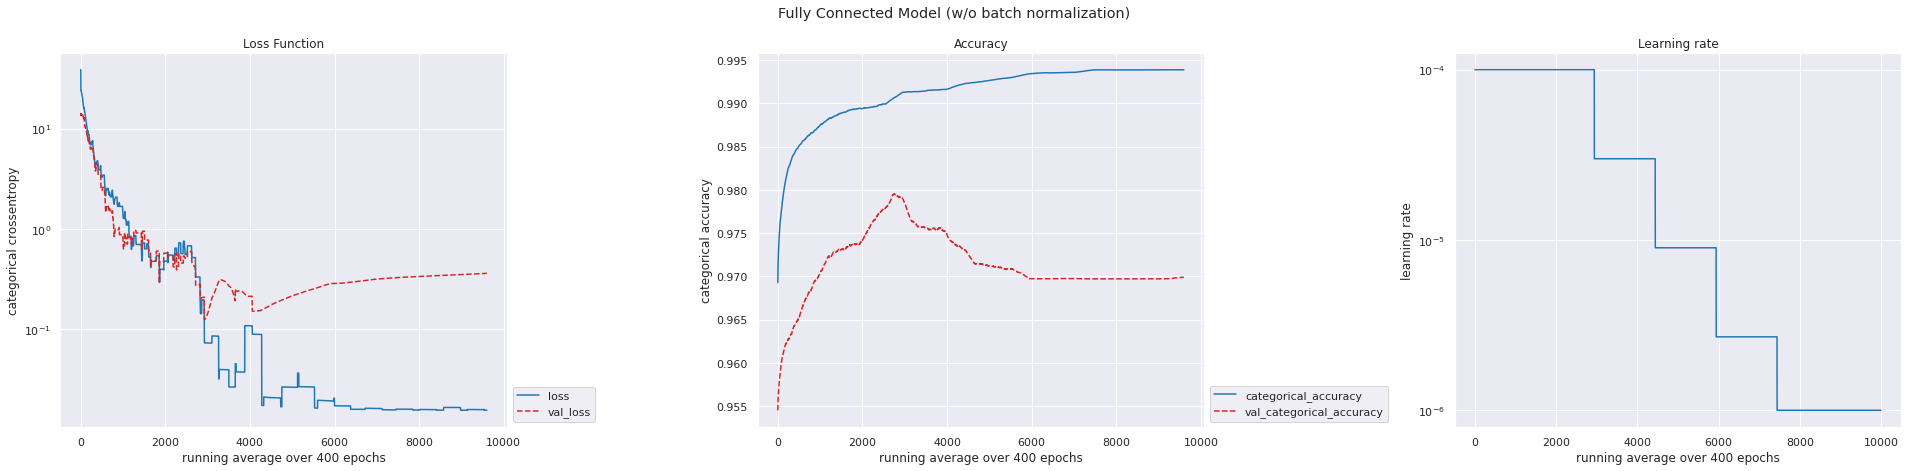

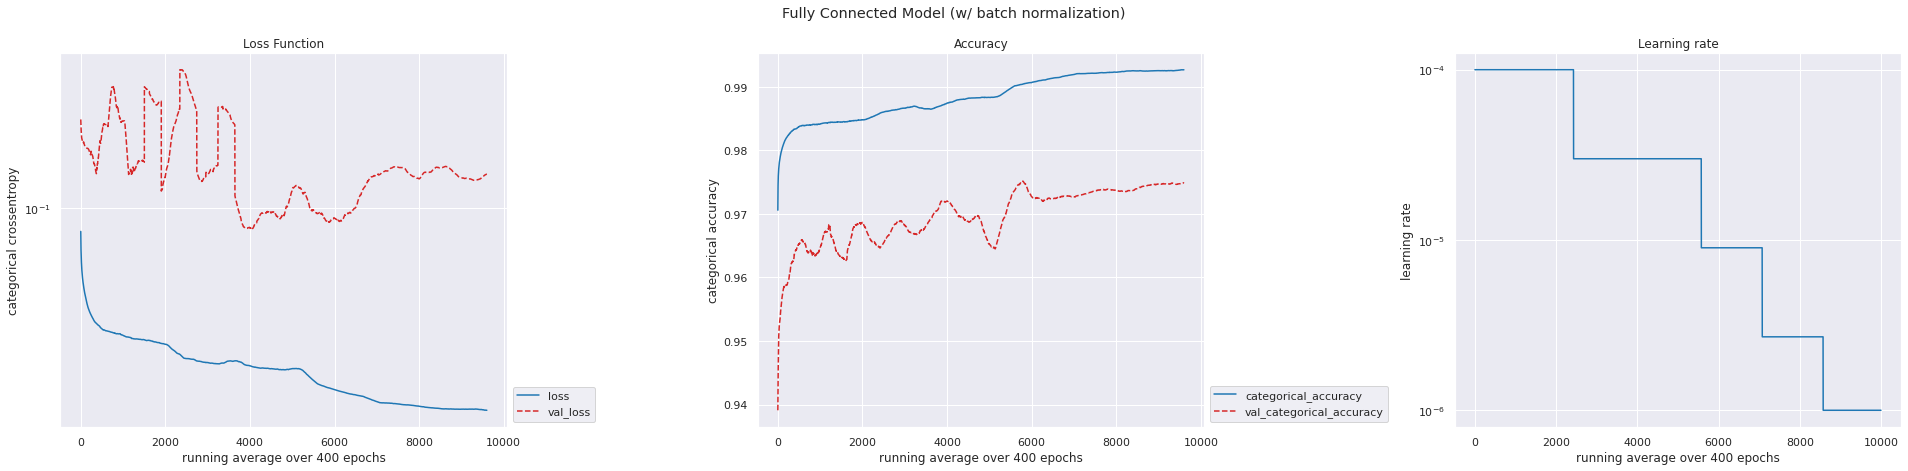

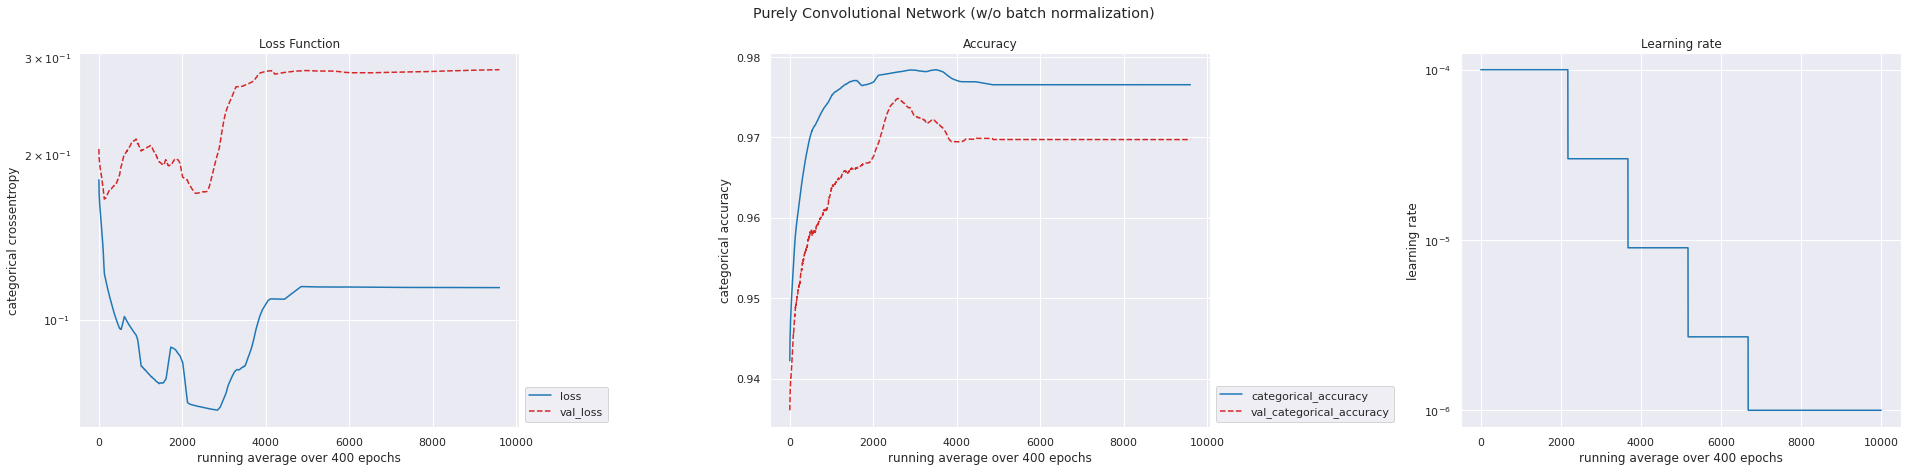

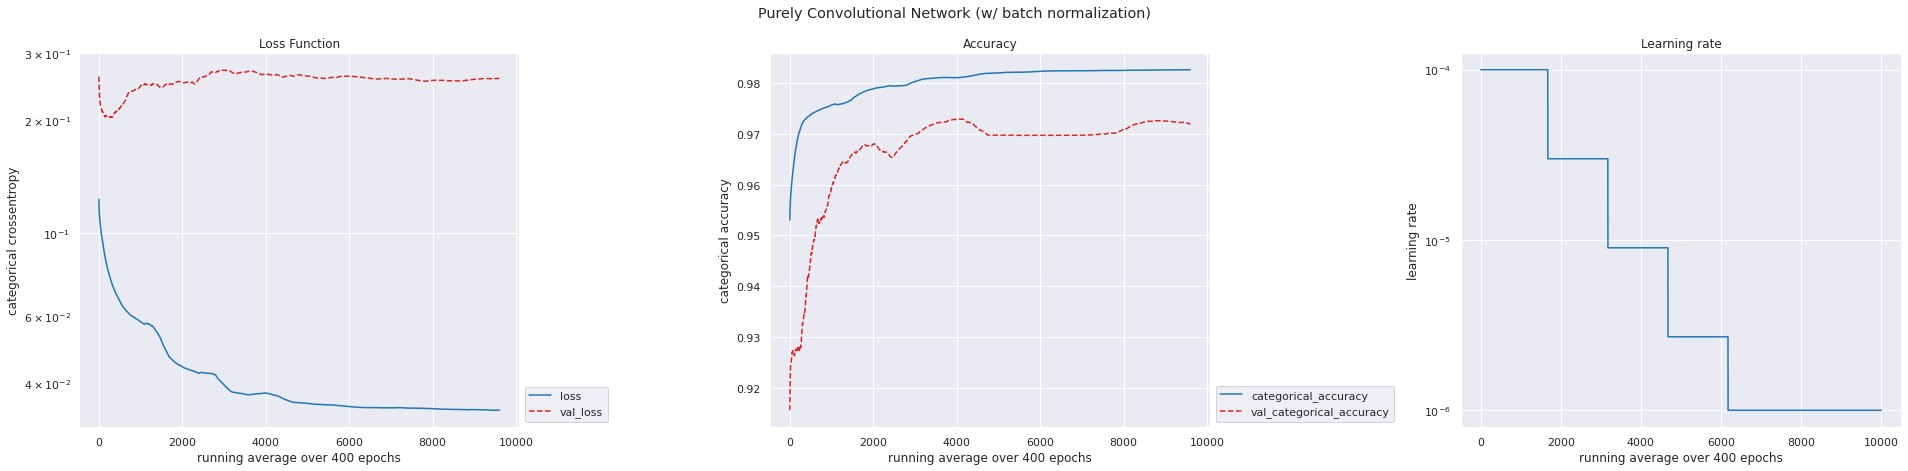

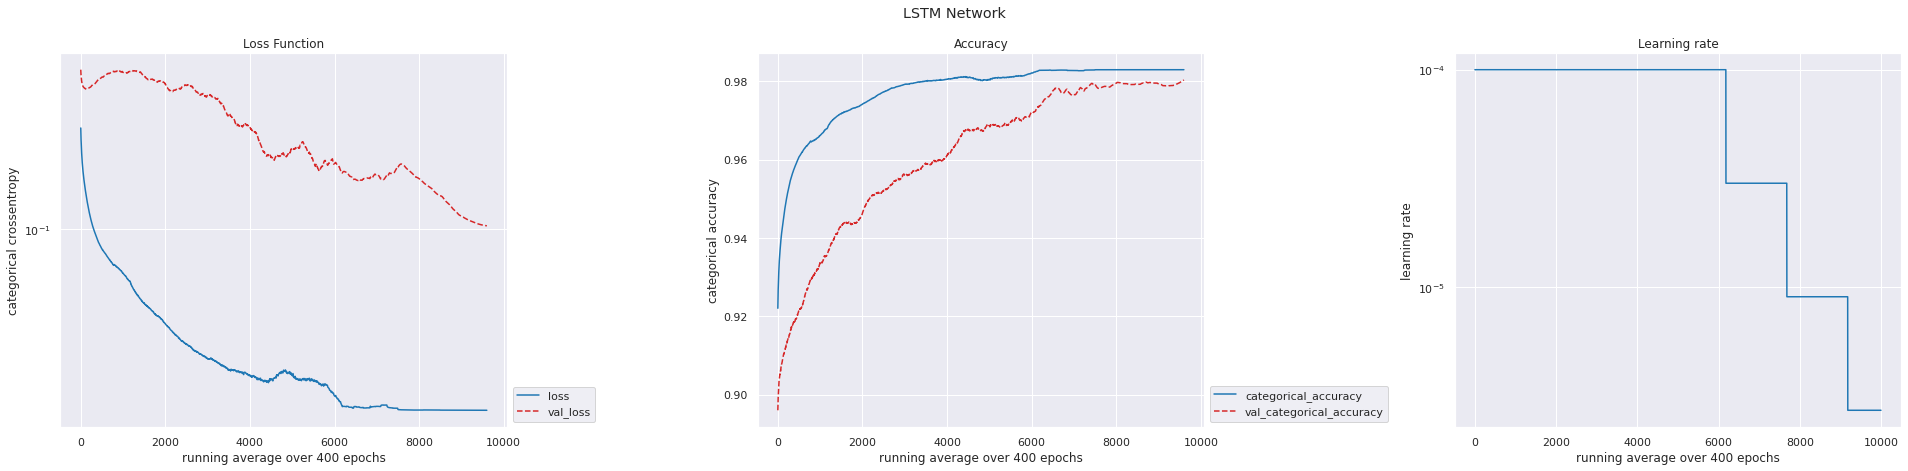

In [25]:
# define a smoothing running average if needed
window = 400

for name in models.keys():
    
    # load the history
    history = load(os.path.join('./models', name, 'history.joblib.gz'))
    
    # plot the loss
    fig, ax = plt.subplots(1, 3, figsize=ratio(3, 1))
    
    plot_history(history,
                 'loss',
                 validation=True,
                 title='Loss Function',
                 xlabel=f'running average over {window:d} epochs',
                 ylabel='categorical crossentropy',
                 logy=True,
                 smooth=True if window > 0 else False,
                 smooth_window=window,
                 #show=True,
                 #save_pdf=True,
                 #out_name=f'{name}_loss_function',
                 #root=os.path.join('./models', name),
                 subplots=(fig, ax[0]),
                )
    
    plot_history(history,
                 'categorical_accuracy',
                 validation=True,
                 title='Accuracy',
                 xlabel=f'running average over {window:d} epochs',
                 ylabel='categorical accuracy',
                 smooth=True if window > 0 else False,
                 smooth_window=window,
                 #show=True,
                 #save_pdf=True,
                 #out_name=f'{name}_categorical_accuracy',
                 #root=os.path.join('./models', name),
                 subplots=(fig, ax[1]),
                )
    
    plot_history(history,
                 'lr',
                 validation=False,
                 title='Learning rate',
                 xlabel=f'running average over {window:d} epochs',
                 ylabel='learning rate',
                 logy=True,
                 #show=True,
                 #save_pdf=True,
                 #out_name=f'{name}_lr',
                 #root=os.path.join('./models', name),
                 subplots=(fig, ax[2]),
                )
    
    fig.suptitle(f'{models_dict[name]}', fontsize='large')
    fig.tight_layout()
    savefig(f'{name}_history', fig, root=os.path.join('./models', name), save_pdf=True, show=True)

We finally use the models to compute the accuracy of the predictions:

In [26]:
predictions = {}
metrics     = {'metrics': ['loss', 'categorical_accuracy', 'recall']}
for name, model in models.items():
    
    # evaluating the model
    print(f'\nEvaluating {name}...')
        
    # compute the predictions
    if bool(re.match('.*_dense', name)):
        
        predictions[name] = model.predict(x=X_test_class).tolist()
        metrics[name]     = model.evaluate(x=X_test_class, y=y_test_class)
        
    if bool(re.match('.*_conv1d', name)):
        
        predictions[name] = model.predict(x=X_test_class_lstm_conv).tolist()
        metrics[name]     = model.evaluate(x=X_test_class_lstm_conv, y=y_test_class_conv)
        
    if bool(re.match('.*_lstm', name)):
        
        predictions[name] = model.predict(x=X_test_class_lstm_conv).tolist()
        metrics[name]     = model.evaluate(x=X_test_class_lstm_conv, y=y_test_class)
    
# save predictions and accuracy
with open(os.path.join('./models', name, 'predictions.json.gz'), 'w') as f:
    json.dump(predictions, f)
with open(os.path.join('./models', name, 'metrics.json.gz'), 'w') as f:
    json.dump(metrics, f)


Evaluating simple_dense...
11/11 [==============================] - 0s 939us/step - loss: 78.0171 - categorical_accuracy: 0.9636

Evaluating bnorm_dense...
11/11 [==============================] - 0s 995us/step - loss: 0.2795 - categorical_accuracy: 0.9636

Evaluating simple_conv1d...
11/11 [==============================] - 0s 1ms/step - loss: 0.4980 - categorical_accuracy: 0.9485

Evaluating bnorm_conv1d...
11/11 [==============================] - 0s 1ms/step - loss: 0.4321 - categorical_accuracy: 0.9333

Evaluating simple_lstm...
11/11 [==============================] - 0s 4ms/step - loss: 0.3539 - categorical_accuracy: 0.9545


It appears therefore that it is possible to classify the models according to the values of *weight*, *type* and the truncation levels (specifically the real part). The following analyses can therefore be made specific to a single physical model, since it can be distinguished from the others.